In [ ]:
# Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)


In [2]:
# Load the dataset
dataset = pd.read_csv("dataset.csv")
dataset.head()


,MMM_TIMESERIES_ID,ORGANISATION_ID,ORGANISATION_VERTICAL,ORGANISATION_SUBVERTICAL,ORGANISATION_MARKETING_SOURCES,ORGANISATION_PRIMARY_TERRITORY_NAME,TERRITORY_NAME,DATE_DAY,CURRENCY_CODE,FIRST_PURCHASES,FIRST_PURCHASES_UNITS,FIRST_PURCHASES_ORIGINAL_PRICE,FIRST_PURCHASES_GROSS_DISCOUNT,ALL_PURCHASES,ALL_PURCHASES_UNITS,ALL_PURCHASES_ORIGINAL_PRICE,ALL_PURCHASES_GROSS_DISCOUNT,GOOGLE_PAID_SEARCH_SPEND,GOOGLE_SHOPPING_SPEND,GOOGLE_PMAX_SPEND,GOOGLE_DISPLAY_SPEND,GOOGLE_VIDEO_SPEND,META_FACEBOOK_SPEND,META_INSTAGRAM_SPEND,META_OTHER_SPEND,TIKTOK_SPEND,GOOGLE_PAID_SEARCH_CLICKS,GOOGLE_SHOPPING_CLICKS,GOOGLE_PMAX_CLICKS,GOOGLE_DISPLAY_CLICKS,GOOGLE_VIDEO_CLICKS,META_FACEBOOK_CLICKS,META_INSTAGRAM_CLICKS,META_OTHER_CLICKS,TIKTOK_CLICKS,GOOGLE_PAID_SEARCH_IMPRESSIONS,GOOGLE_SHOPPING_IMPRESSIONS,GOOGLE_PMAX_IMPRESSIONS,GOOGLE_DISPLAY_IMPRESSIONS,GOOGLE_VIDEO_IMPRESSIONS,META_FACEBOOK_IMPRESSIONS,META_INSTAGRAM_IMPRESSIONS,META_OTHER_IMPRESSIONS,TIKTOK_IMPRESSIONS,DIRECT_CLICKS,BRANDED_SEARCH_CLICKS,ORGANIC_SEARCH_CLICKS,EMAIL_CLICKS,REFERRAL_CLICKS,ALL_OTHER_CLICKS
0,596eef7c71f933d820d0e485935d0e8f,04769dac8b828ec7a85676d9e2bffe6f,Beauty & Fitness,Hair Care,"Google, Meta",US,All Territories,2022-07-29,USD,22,27,3837.980834,632.595555,27,32,4552.984240,846.593069,NaN,NaN,205.528905,NaN,NaN,233.75,NaN,NaN,NaN,NaN,NaN,255.0,NaN,NaN,163.0,NaN,NaN,NaN,NaN,NaN,31907.0,NaN,NaN,18997.0,NaN,NaN,NaN,139.0,NaN,300.0,1.0,61.0,40.0
1,596eef7c71f933d820d0e485935d0e8f,04769dac8b828ec7a85676d9e2bffe6f,Beauty & Fitness,Hair Care,"Google, Meta",US,All Territories,2022-07-30,USD,14,21,2747.998631,443.996522,17,26,3177.998032,613.806522,NaN,NaN,277.082025,NaN,NaN,248.84,NaN,NaN,NaN,NaN,NaN,348.0,NaN,NaN,128.0,NaN,NaN,NaN,NaN,NaN,44483.0,NaN,NaN,20188.0,NaN,NaN,NaN,209.0,NaN,442.0,8.0,110.0,62.0
2,596eef7c71f933d820d0e485935d0e8f,04769dac8b828ec7a85676d9e2bffe6f,Beauty & Fitness,Hair Care,"Google, Meta",US,All Territories,2022-07-31,USD,31,39,4567.998818,1185.197966,39,48,5468.998818,1504.997966,NaN,NaN,427.436429,NaN,NaN,274.51,NaN,NaN,NaN,NaN,NaN,405.0,NaN,NaN,148.0,NaN,NaN,NaN,NaN,NaN,58173.0,NaN,NaN,24718.0,NaN,NaN,NaN,262.0,NaN,427.0,631.0,108.0,65.0
3,596eef7c71f933d820d0e485935d0e8f,04769dac8b828ec7a85676d9e2bffe6f,Beauty & Fitness,Hair Care,"Google, Meta",US,All Territories,2022-08-01,USD,18,30,2878.982385,696.519993,22,34,3335.970202,754.410747,35.24,NaN,347.232798,NaN,NaN,270.06,NaN,NaN,NaN,48.0,NaN,320.0,NaN,NaN,163.0,NaN,NaN,NaN,890.0,NaN,55559.0,NaN,NaN,25076.0,NaN,NaN,NaN,247.0,NaN,400.0,117.0,125.0,68.0
4,596eef7c71f933d820d0e485935d0e8f,04769dac8b828ec7a85676d9e2bffe6f,Beauty & Fitness,Hair Care,"Google, Meta",US,All Territories,2022-08-02,USD,23,27,3107.993669,627.097427,28,33,3991.987441,934.011083,38.40,NaN,314.952971,NaN,NaN,257.62,NaN,NaN,NaN,46.0,NaN,330.0,NaN,NaN,127.0,NaN,NaN,NaN,702.0,NaN,47854.0,NaN,NaN,22688.0,NaN,NaN,NaN,255.0,NaN,425.0,37.0,146.0,65.0


In [3]:
# Define columns to impute
columns_to_impute = [
    # Google spend
    'GOOGLE_PAID_SEARCH_SPEND','GOOGLE_SHOPPING_SPEND','GOOGLE_PMAX_SPEND','GOOGLE_DISPLAY_SPEND','GOOGLE_VIDEO_SPEND',
    # Google impressions
    'GOOGLE_PAID_SEARCH_IMPRESSIONS','GOOGLE_SHOPPING_IMPRESSIONS','GOOGLE_PMAX_IMPRESSIONS','GOOGLE_DISPLAY_IMPRESSIONS','GOOGLE_VIDEO_IMPRESSIONS',
    # Google clicks
    'GOOGLE_PAID_SEARCH_CLICKS','GOOGLE_SHOPPING_CLICKS','GOOGLE_PMAX_CLICKS','GOOGLE_DISPLAY_CLICKS','GOOGLE_VIDEO_CLICKS',
    # Meta spend
    'META_FACEBOOK_SPEND','META_INSTAGRAM_SPEND','META_OTHER_SPEND',
    # Meta impressions
    'META_FACEBOOK_IMPRESSIONS','META_INSTAGRAM_IMPRESSIONS','META_OTHER_IMPRESSIONS',
    # Meta clicks
    'META_FACEBOOK_CLICKS','META_INSTAGRAM_CLICKS','META_OTHER_CLICKS',
    # TikTok
    'TIKTOK_SPEND','TIKTOK_IMPRESSIONS','TIKTOK_CLICKS',
    # Other clicks
    'DIRECT_CLICKS','BRANDED_SEARCH_CLICKS','ORGANIC_SEARCH_CLICKS','EMAIL_CLICKS','REFERRAL_CLICKS','ALL_OTHER_CLICKS'
]

# Create a copy and fill NaNs with 0
dataset_imputed = dataset.copy()
dataset_imputed[columns_to_impute] = dataset_imputed[columns_to_impute].fillna(0)


In [4]:
# Creating engineered features
new_dataset = dataset_imputed.copy()

# Click columns
click_columns = ['GOOGLE_PAID_SEARCH_CLICKS','GOOGLE_SHOPPING_CLICKS','GOOGLE_PMAX_CLICKS','GOOGLE_DISPLAY_CLICKS','GOOGLE_VIDEO_CLICKS',
                'META_FACEBOOK_CLICKS','META_INSTAGRAM_CLICKS','META_OTHER_CLICKS','TIKTOK_CLICKS',
                'DIRECT_CLICKS','BRANDED_SEARCH_CLICKS','ORGANIC_SEARCH_CLICKS','EMAIL_CLICKS','REFERRAL_CLICKS','ALL_OTHER_CLICKS']

# Adding total clicks column
new_dataset['TOTAL_CLICKS'] = new_dataset[click_columns].sum(axis=1)

# Impression columns
impression_columns = ['GOOGLE_PAID_SEARCH_IMPRESSIONS','GOOGLE_SHOPPING_IMPRESSIONS','GOOGLE_PMAX_IMPRESSIONS','GOOGLE_DISPLAY_IMPRESSIONS','GOOGLE_VIDEO_IMPRESSIONS',
                      'META_FACEBOOK_IMPRESSIONS','META_INSTAGRAM_IMPRESSIONS','META_OTHER_IMPRESSIONS',
                      'TIKTOK_IMPRESSIONS']

# Adding total impressions column
new_dataset['TOTAL_IMPRESSIONS'] = new_dataset[impression_columns].sum(axis=1)

# Spend columns
spend_columns = ['GOOGLE_PAID_SEARCH_SPEND','GOOGLE_SHOPPING_SPEND','GOOGLE_PMAX_SPEND','GOOGLE_DISPLAY_SPEND','GOOGLE_VIDEO_SPEND',
                'META_FACEBOOK_SPEND','META_INSTAGRAM_SPEND','META_OTHER_SPEND',
                'TIKTOK_SPEND']

# Adding total spend column
new_dataset['TOTAL_SPEND'] = new_dataset[spend_columns].sum(axis=1)

# Create target variables
new_dataset["ROI"] = new_dataset["ALL_PURCHASES"] / new_dataset["TOTAL_SPEND"]
new_dataset["ROI_RETURNING"] = (new_dataset["ALL_PURCHASES"] - new_dataset["FIRST_PURCHASES"]) / new_dataset["TOTAL_SPEND"]
new_dataset["ROI_FIRST"] = new_dataset["FIRST_PURCHASES"] / new_dataset["TOTAL_SPEND"]
new_dataset["CTR"] = new_dataset["TOTAL_CLICKS"] / new_dataset["TOTAL_IMPRESSIONS"]
new_dataset["CP_DOLLAR"] = new_dataset["TOTAL_SPEND"] / new_dataset["TOTAL_CLICKS"]

# Handle division by zero
new_dataset.replace([np.inf, -np.inf], np.nan, inplace=True)
new_dataset.fillna(0, inplace=True)


In [5]:
# Calculate percentiles for TOTAL_SPEND
lower_percentile = new_dataset['TOTAL_SPEND'].quantile(0.05)
upper_percentile = new_dataset['TOTAL_SPEND'].quantile(0.995)

# Filter out TOTAL_SPEND outliers
mask = (new_dataset['TOTAL_SPEND'] >= lower_percentile) & (new_dataset['TOTAL_SPEND'] <= upper_percentile)
new_dataset = new_dataset[mask]


In [6]:
# Remove outliers using quantiles
target_variables = ['ROI_FIRST', 'ROI', 'ROI_RETURNING', 'CTR', 'CP_DOLLAR']

# Calculate 0.5th and 99.5th percentiles for each target variable
lower_percentile = new_dataset[target_variables].quantile(0.005)
upper_percentile = new_dataset[target_variables].quantile(0.995)

# Filter out outliers - keep rows where ALL target variables are within bounds
mask = True
for var in target_variables:
    mask = mask & (new_dataset[var] >= lower_percentile[var]) & (new_dataset[var] <= upper_percentile[var]) & (new_dataset[var] != 0)

new_dataset = new_dataset[mask]

# Target variables statistics
new_dataset[target_variables].describe()


,ROI_FIRST,ROI,ROI_RETURNING,CTR,CP_DOLLAR
count,116182.000000,116182.000000,116182.000000,116182.000000,116182.000000
mean,0.085169,0.123403,0.038234,0.031645,0.451959
std,0.108372,0.155800,0.069431,0.036781,0.469631
min,0.001642,0.002505,0.000104,0.005051,0.018794
25%,0.028202,0.040870,0.008862,0.015999,0.190092
50%,0.054846,0.077137,0.019112,0.022873,0.318383
75%,0.100703,0.143138,0.037707,0.034292,0.546632
max,1.296720,2.002427,0.891005,0.638579,6.008413


In [7]:
# Drop columns that would give away information about the target variable
new_dataset = new_dataset.drop(columns=['FIRST_PURCHASES', 'ALL_PURCHASES'])
new_dataset = new_dataset.drop(columns=click_columns)

# Remove purchase outcome columns
purchase_outcome_columns = ['FIRST_PURCHASES_UNITS', 'FIRST_PURCHASES_ORIGINAL_PRICE', 'FIRST_PURCHASES_GROSS_DISCOUNT',
                            'ALL_PURCHASES_UNITS', 'ALL_PURCHASES_ORIGINAL_PRICE', 'ALL_PURCHASES_GROSS_DISCOUNT',
                            'TOTAL_CLICKS']
new_dataset = new_dataset.drop(columns=purchase_outcome_columns)


In [8]:
# Select only numeric columns for modeling
model_dataset = new_dataset.select_dtypes(include=[np.number])


In [9]:
# Sample 12,000 random entries
sampled_data = model_dataset.sample(n=12000, random_state=42)

# Split features and targets
X = sampled_data.drop(columns=target_variables)
y = sampled_data[target_variables]

# Split into train (10,000) and test (2,000)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=2000, train_size=10000, random_state=42)

In [10]:
# Define hyperparameter grid for XGBoost
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Set up k-fold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)


In [11]:
# Dictionary to store models and results
models = {}
results = {}
best_params = {}

# Train a model for each target variable
for target in target_variables:
    # Create base XGBoost model
    xgb_model = xgb.XGBRegressor(
        objective='reg:squarederror',
        random_state=42,
        n_jobs=-1
    )
    
    # Grid search with cross-validation
    grid_search = GridSearchCV(
        estimator=xgb_model,
        param_grid=param_grid,
        cv=kfold,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=1
    )
    
    # Fit the model
    grid_search.fit(X_train, y_train[target])
    
    # Store the best model
    models[target] = grid_search.best_estimator_
    best_params[target] = grid_search.best_params_
    
    # Make predictions
    y_pred = grid_search.predict(X_test)
    
    # Calculate metrics
    mse = mean_squared_error(y_test[target], y_pred)
    r2 = r2_score(y_test[target], y_pred)
    
    # Store results
    results[target] = {
        'mse': mse,
        'rmse': np.sqrt(mse),
        'r2': r2,
        'y_pred': y_pred,
        'y_true': y_test[target].values,
    }
    
    print(f"\nBest parameters: {grid_search.best_params_}")
    print(f"Best CV score (MSE): {-grid_search.best_score_:.6f}")
    print(f"Test MSE: {mse:.6f}")
    print(f"Test RMSE: {np.sqrt(mse):.6f}")
    print(f"Test R²: {r2:.6f}")


Fitting 5 folds for each of 108 candidates, totalling 540 fits



Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.8}
Best CV score (MSE): 0.004800
Test MSE: 0.004524
Test RMSE: 0.067262
Test R²: 0.577651
Fitting 5 folds for each of 108 candidates, totalling 540 fits

Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}
Best CV score (MSE): 0.009514
Test MSE: 0.007104
Test RMSE: 0.084284
Test R²: 0.657002
Fitting 5 folds for each of 108 candidates, totalling 540 fits

Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.8}
Best CV score (MSE): 0.002432
Test MSE: 0.002648
Test RMSE: 0.051463
Test R²: 0.334714
Fitting 5 folds for each of 108 candidates, totalling 540 fits

Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.8}
Best CV score (MSE): 0.000525
Test MSE: 0.000437
Test RMSE: 0.0208

In [13]:
# Create summary DataFrame
summary_df = pd.DataFrame({
    'Target': target_variables,
    'MSE': [results[t]['mse'] for t in target_variables],
    'RMSE': [results[t]['rmse'] for t in target_variables],
    'R²': [results[t]['r2'] for t in target_variables],
})
print(summary_df.to_string(index=False))

# Display as a nice table
summary_df


       Target      MSE     RMSE       R²
    ROI_FIRST 0.004524 0.067262 0.577651
          ROI 0.007104 0.084284 0.657002
ROI_RETURNING 0.002648 0.051463 0.334714
          CTR 0.000437 0.020899 0.531902
    CP_DOLLAR 0.051863 0.227734 0.731251


,Target,MSE,RMSE,R²
0,ROI_FIRST,0.004524,0.067262,0.577651
1,ROI,0.007104,0.084284,0.657002
2,ROI_RETURNING,0.002648,0.051463,0.334714
3,CTR,0.000437,0.020899,0.531902
4,CP_DOLLAR,0.051863,0.227734,0.731251


In [14]:
for target in target_variables:
    print(f"\n{target}:")
    for param, value in best_params[target].items():
        print(f"  {param}: {value}")



ROI_FIRST:
  colsample_bytree: 0.8
  learning_rate: 0.1
  max_depth: 7
  n_estimators: 100
  subsample: 0.8

ROI:
  colsample_bytree: 1.0
  learning_rate: 0.1
  max_depth: 7
  n_estimators: 200
  subsample: 0.8

ROI_RETURNING:
  colsample_bytree: 0.8
  learning_rate: 0.1
  max_depth: 7
  n_estimators: 100
  subsample: 0.8

CTR:
  colsample_bytree: 0.8
  learning_rate: 0.1
  max_depth: 7
  n_estimators: 300
  subsample: 0.8

CP_DOLLAR:
  colsample_bytree: 0.8
  learning_rate: 0.1
  max_depth: 5
  n_estimators: 200
  subsample: 0.8


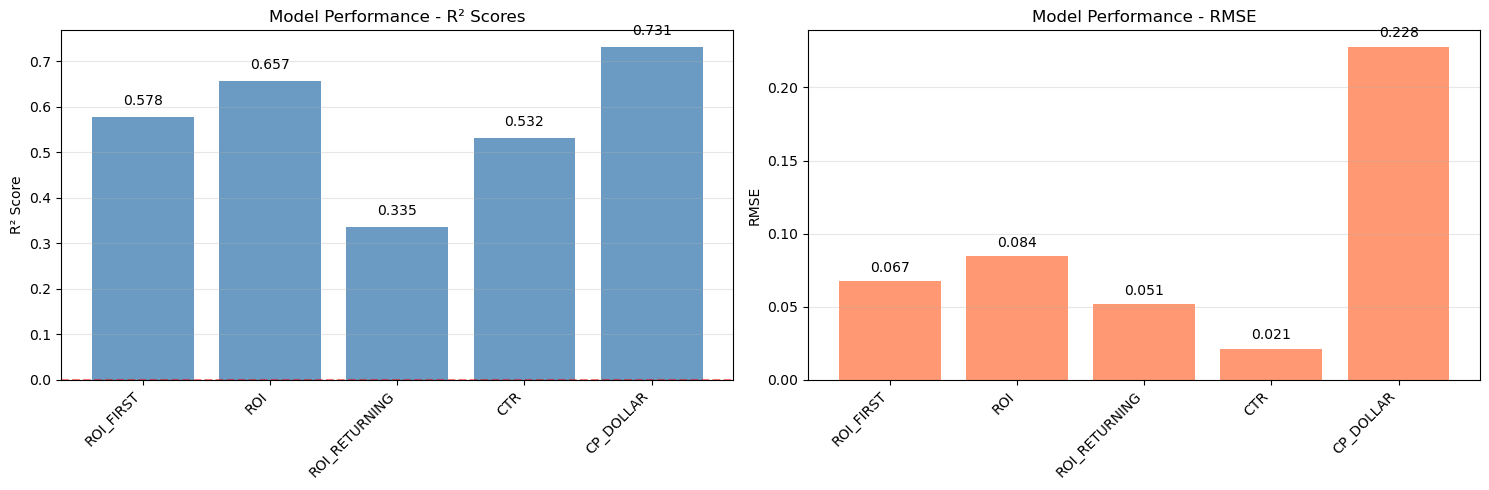

In [15]:
# Plot 1: Model Performance Comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# R² scores
r2_scores = [results[t]['r2'] for t in target_variables]
axes[0].bar(range(len(target_variables)), r2_scores, color='steelblue', alpha=0.8)
axes[0].set_xticks(range(len(target_variables)))
axes[0].set_xticklabels(target_variables, rotation=45, ha='right')
axes[0].set_ylabel('R² Score')
axes[0].set_title('Model Performance - R² Scores')
axes[0].grid(axis='y', alpha=0.3)
axes[0].axhline(y=0, color='red', linestyle='--', alpha=0.5)

# Add value labels on bars
for i, v in enumerate(r2_scores):
    axes[0].text(i, v + 0.02, f'{v:.3f}', ha='center', va='bottom')

# RMSE scores
rmse_scores = [results[t]['rmse'] for t in target_variables]
axes[1].bar(range(len(target_variables)), rmse_scores, color='coral', alpha=0.8)
axes[1].set_xticks(range(len(target_variables)))
axes[1].set_xticklabels(target_variables, rotation=45, ha='right')
axes[1].set_ylabel('RMSE')
axes[1].set_title('Model Performance - RMSE')
axes[1].grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, v in enumerate(rmse_scores):
    axes[1].text(i, v + max(rmse_scores)*0.02, f'{v:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


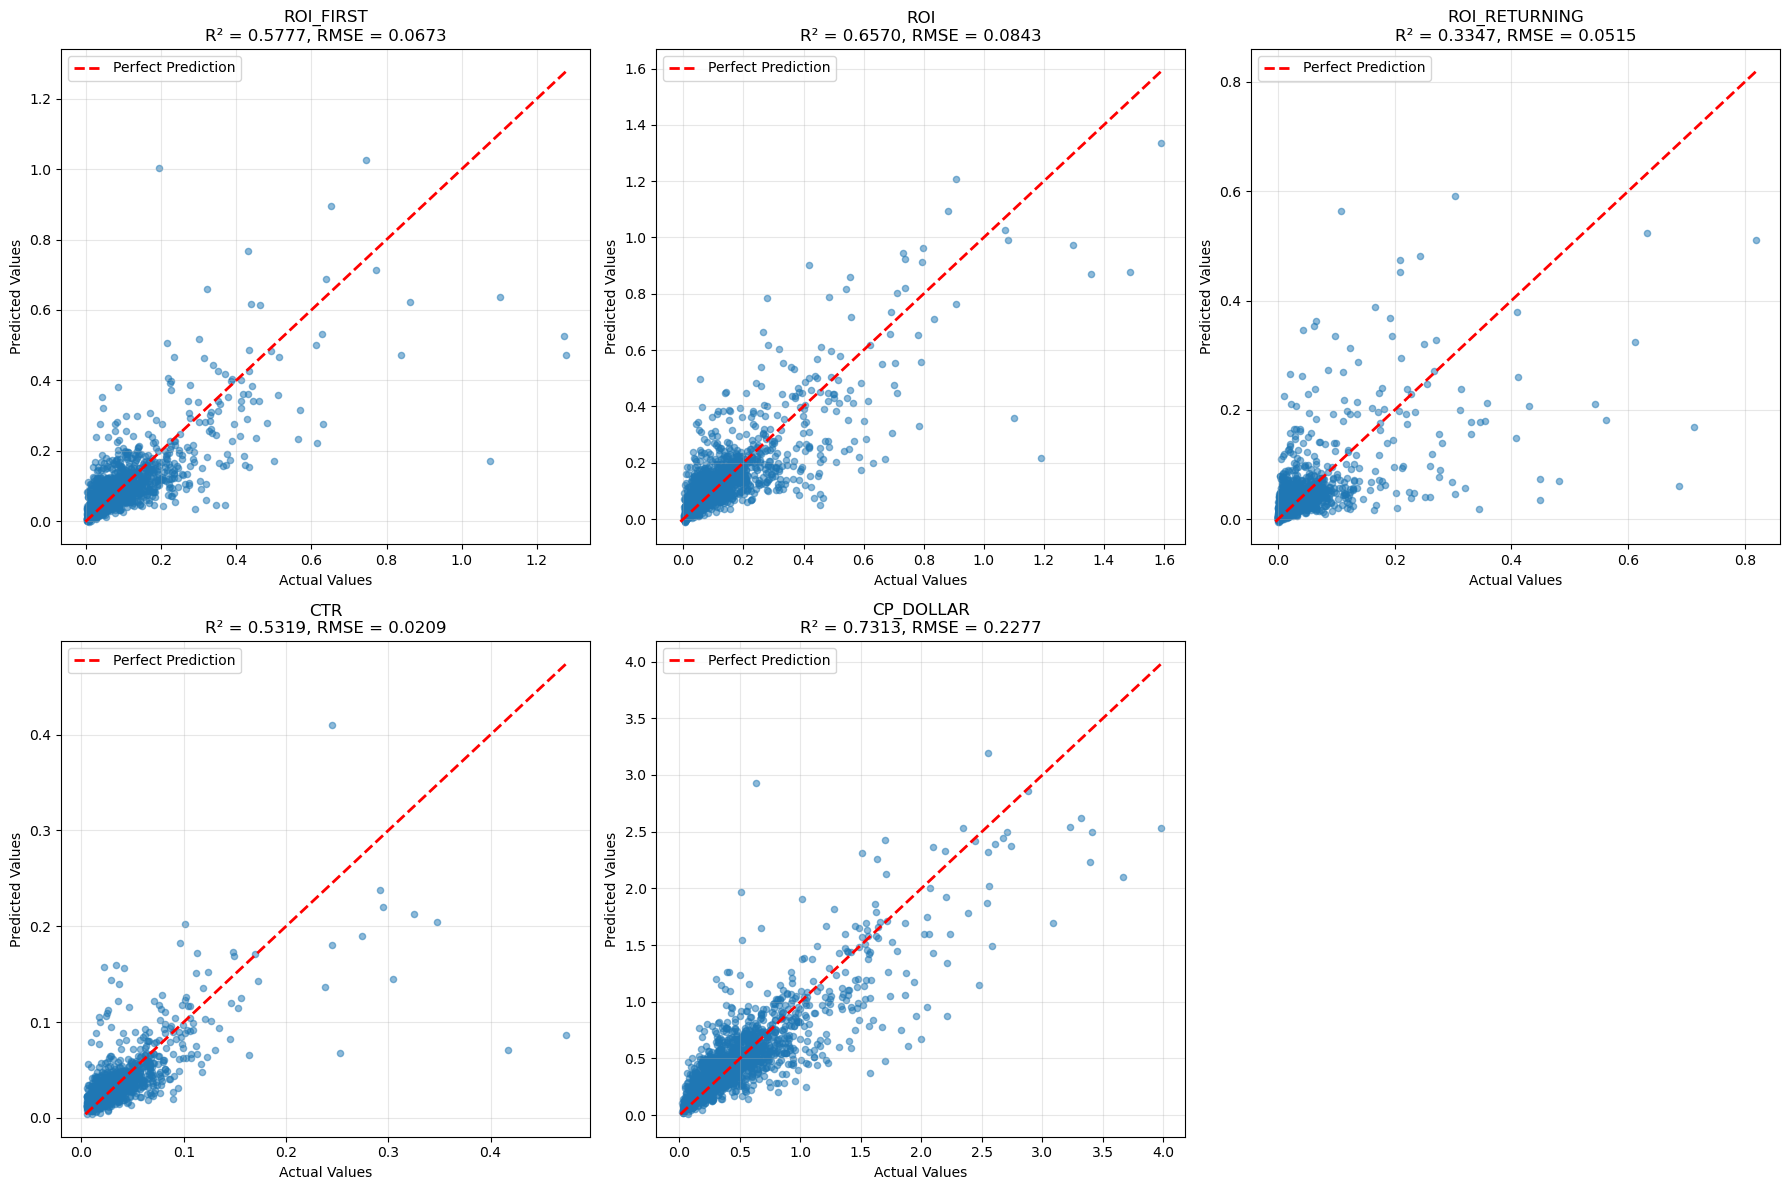

In [16]:
# Plot 2: Predicted vs Actual for each target variable
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, target in enumerate(target_variables):
    y_true = results[target]['y_true']
    y_pred = results[target]['y_pred']
    
    # Scatter plot
    axes[idx].scatter(y_true, y_pred, alpha=0.5, s=20)
    
    # Perfect prediction line
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    axes[idx].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
    
    axes[idx].set_xlabel('Actual Values')
    axes[idx].set_ylabel('Predicted Values')
    axes[idx].set_title(f'{target}\nR² = {results[target]["r2"]:.4f}, RMSE = {results[target]["rmse"]:.4f}')
    axes[idx].legend()
    axes[idx].grid(alpha=0.3)

# Hide the extra subplot
axes[5].axis('off')

plt.tight_layout()
plt.show()


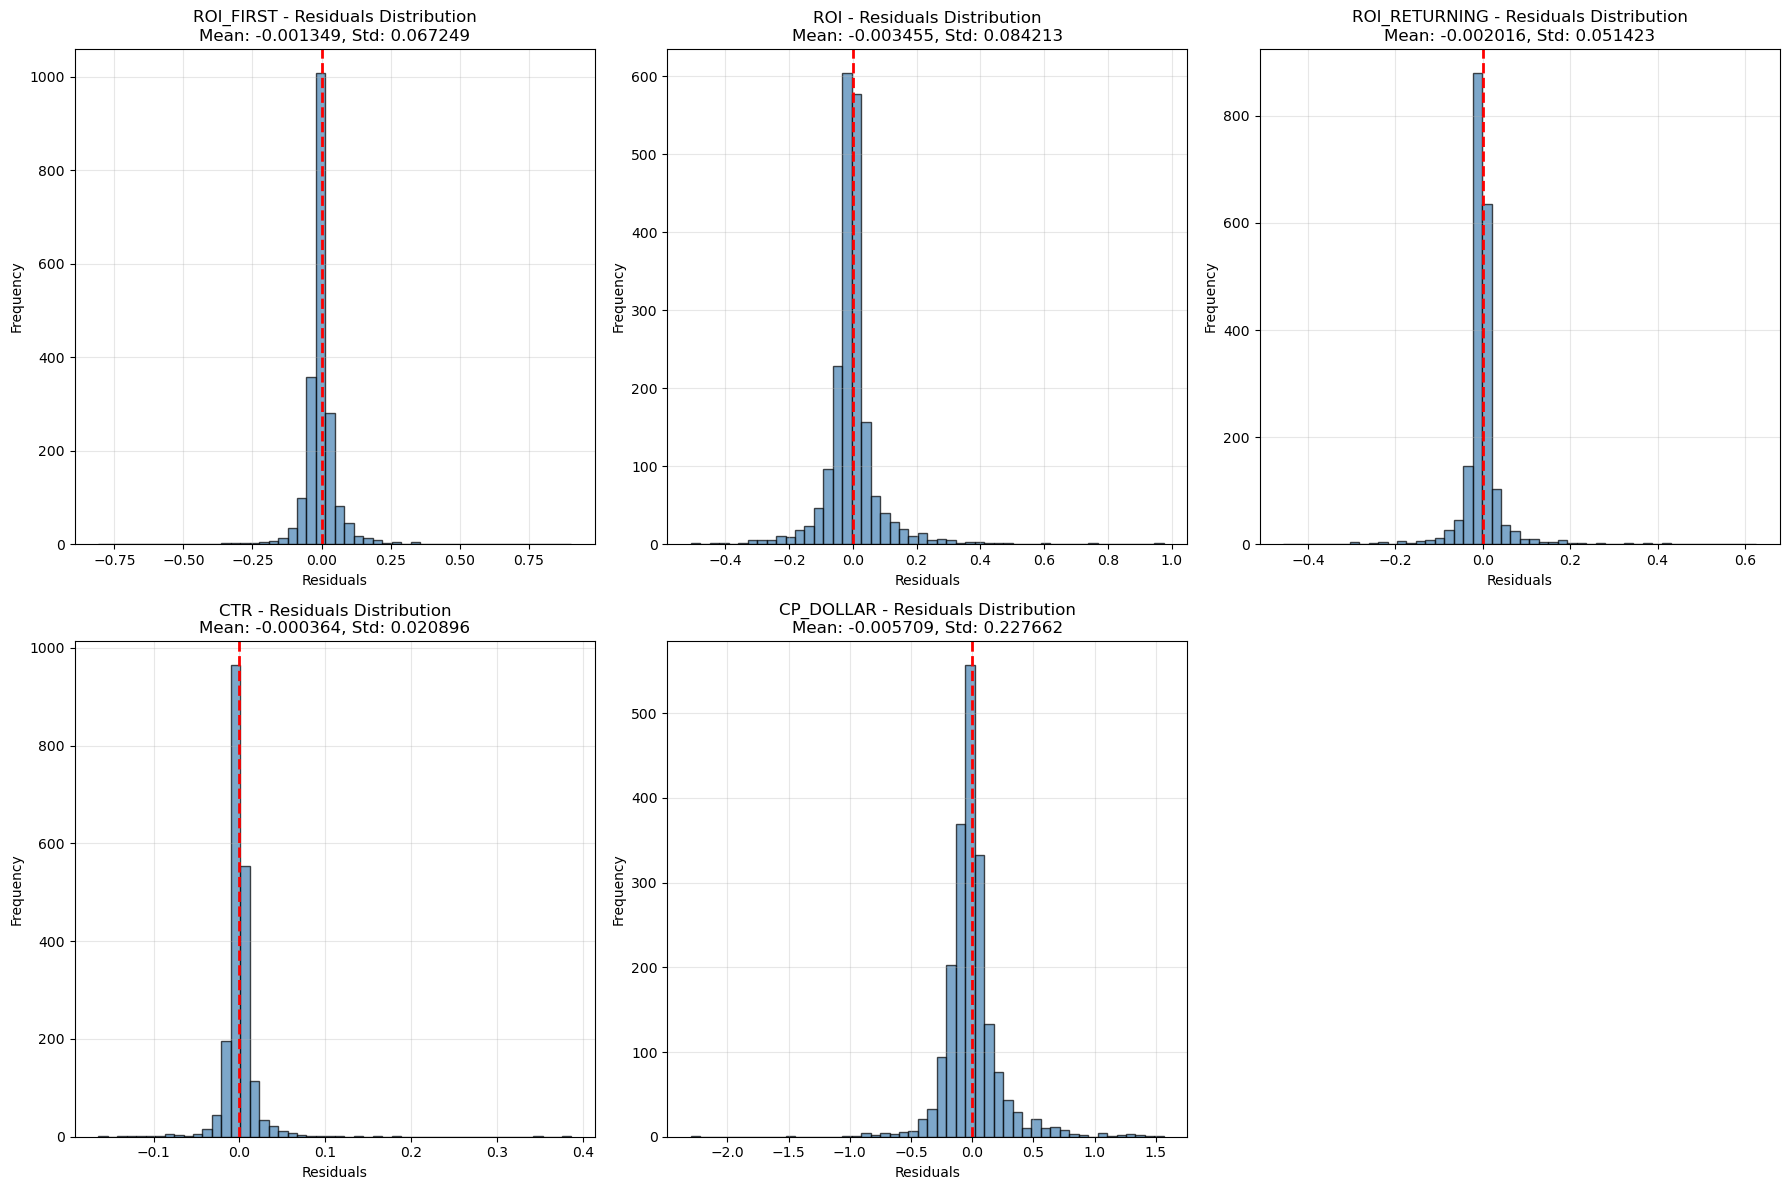

In [17]:
# Plot 3: Residuals Distribution
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, target in enumerate(target_variables):
    y_true = results[target]['y_true']
    y_pred = results[target]['y_pred']
    residuals = y_true - y_pred
    
    # Histogram of residuals
    axes[idx].hist(residuals, bins=50, alpha=0.7, color='steelblue', edgecolor='black')
    axes[idx].axvline(x=0, color='red', linestyle='--', lw=2)
    axes[idx].set_xlabel('Residuals')
    axes[idx].set_ylabel('Frequency')
    axes[idx].set_title(f'{target} - Residuals Distribution\nMean: {residuals.mean():.6f}, Std: {residuals.std():.6f}')
    axes[idx].grid(alpha=0.3)

# Hide the extra subplot
axes[5].axis('off')

plt.tight_layout()
plt.show()


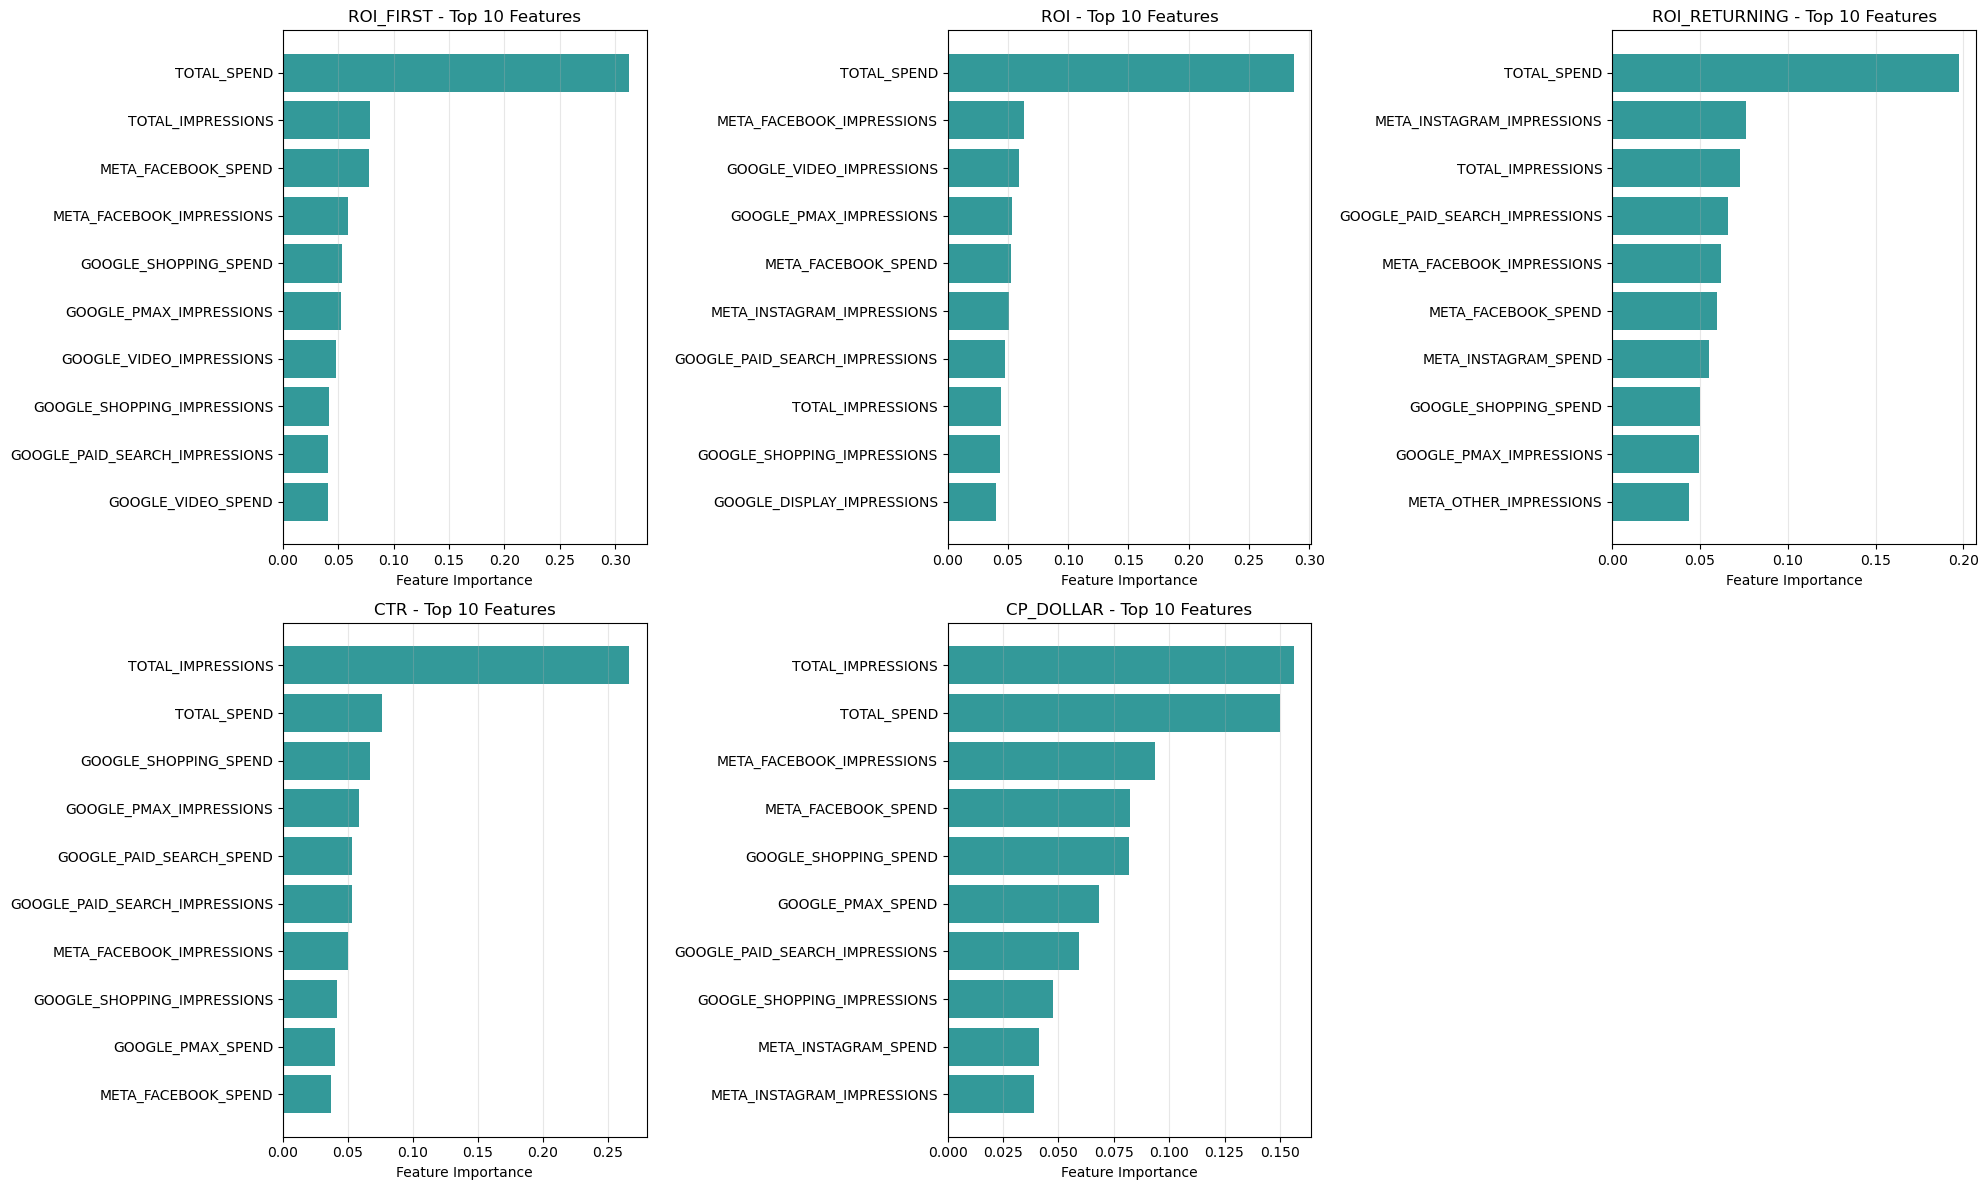

In [18]:
# Plot 4: Feature Importance for each model
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

for idx, target in enumerate(target_variables):
    model = models[target]
    
    # Get feature importances
    importance = model.feature_importances_
    feature_names = X_train.columns
    
    # Sort by importance
    indices = np.argsort(importance)[::-1][:10]  # Top 10 features
    
    # Plot
    axes[idx].barh(range(len(indices)), importance[indices], color='teal', alpha=0.8)
    axes[idx].set_yticks(range(len(indices)))
    axes[idx].set_yticklabels([feature_names[i] for i in indices])
    axes[idx].set_xlabel('Feature Importance')
    axes[idx].set_title(f'{target} - Top 10 Features')
    axes[idx].grid(axis='x', alpha=0.3)
    axes[idx].invert_yaxis()

# Hide the extra subplot
axes[5].axis('off')

plt.tight_layout()
plt.show()


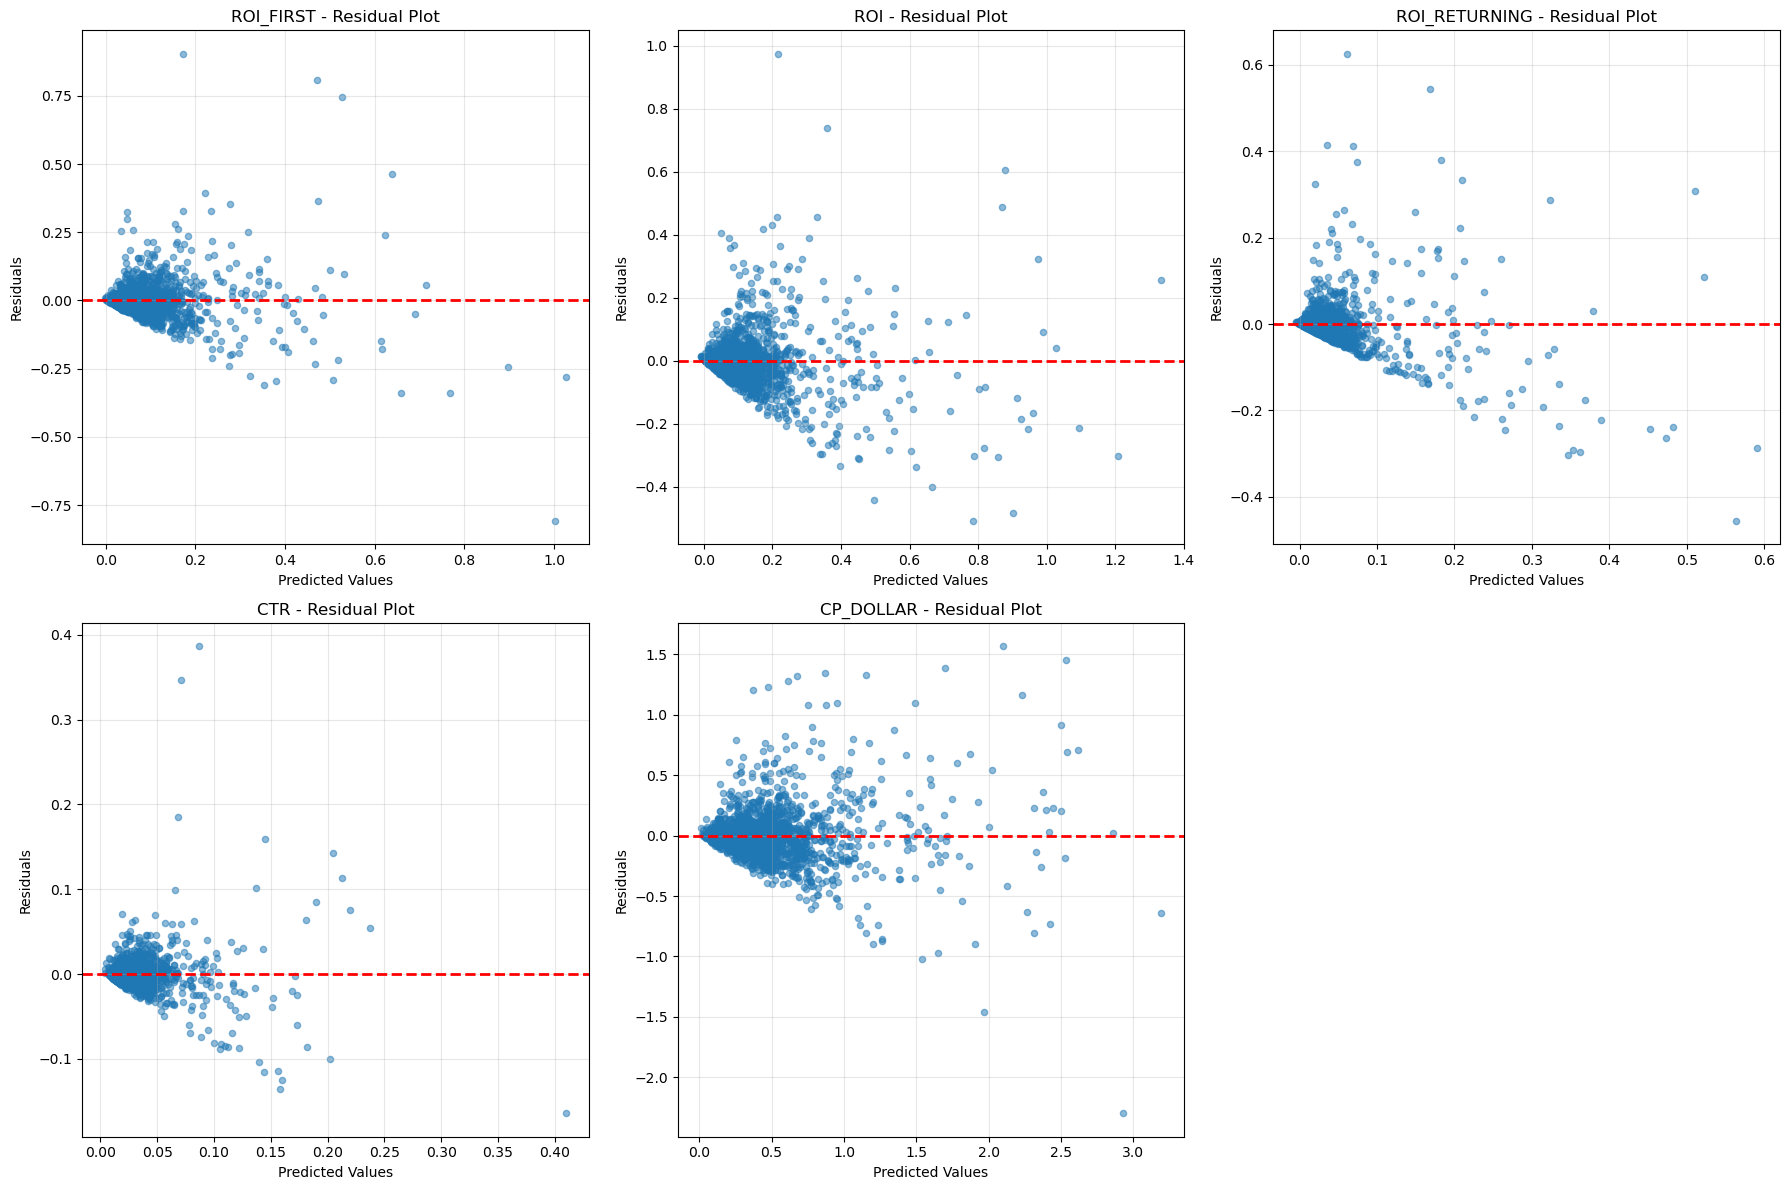

In [19]:
# Plot 5: Residuals vs Predicted Values (to check for heteroscedasticity)
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, target in enumerate(target_variables):
    y_true = results[target]['y_true']
    y_pred = results[target]['y_pred']
    residuals = y_true - y_pred
    
    # Scatter plot of residuals vs predicted
    axes[idx].scatter(y_pred, residuals, alpha=0.5, s=20)
    axes[idx].axhline(y=0, color='red', linestyle='--', lw=2)
    axes[idx].set_xlabel('Predicted Values')
    axes[idx].set_ylabel('Residuals')
    axes[idx].set_title(f'{target} - Residual Plot')
    axes[idx].grid(alpha=0.3)

# Hide the extra subplot
axes[5].axis('off')

plt.tight_layout()
plt.show()


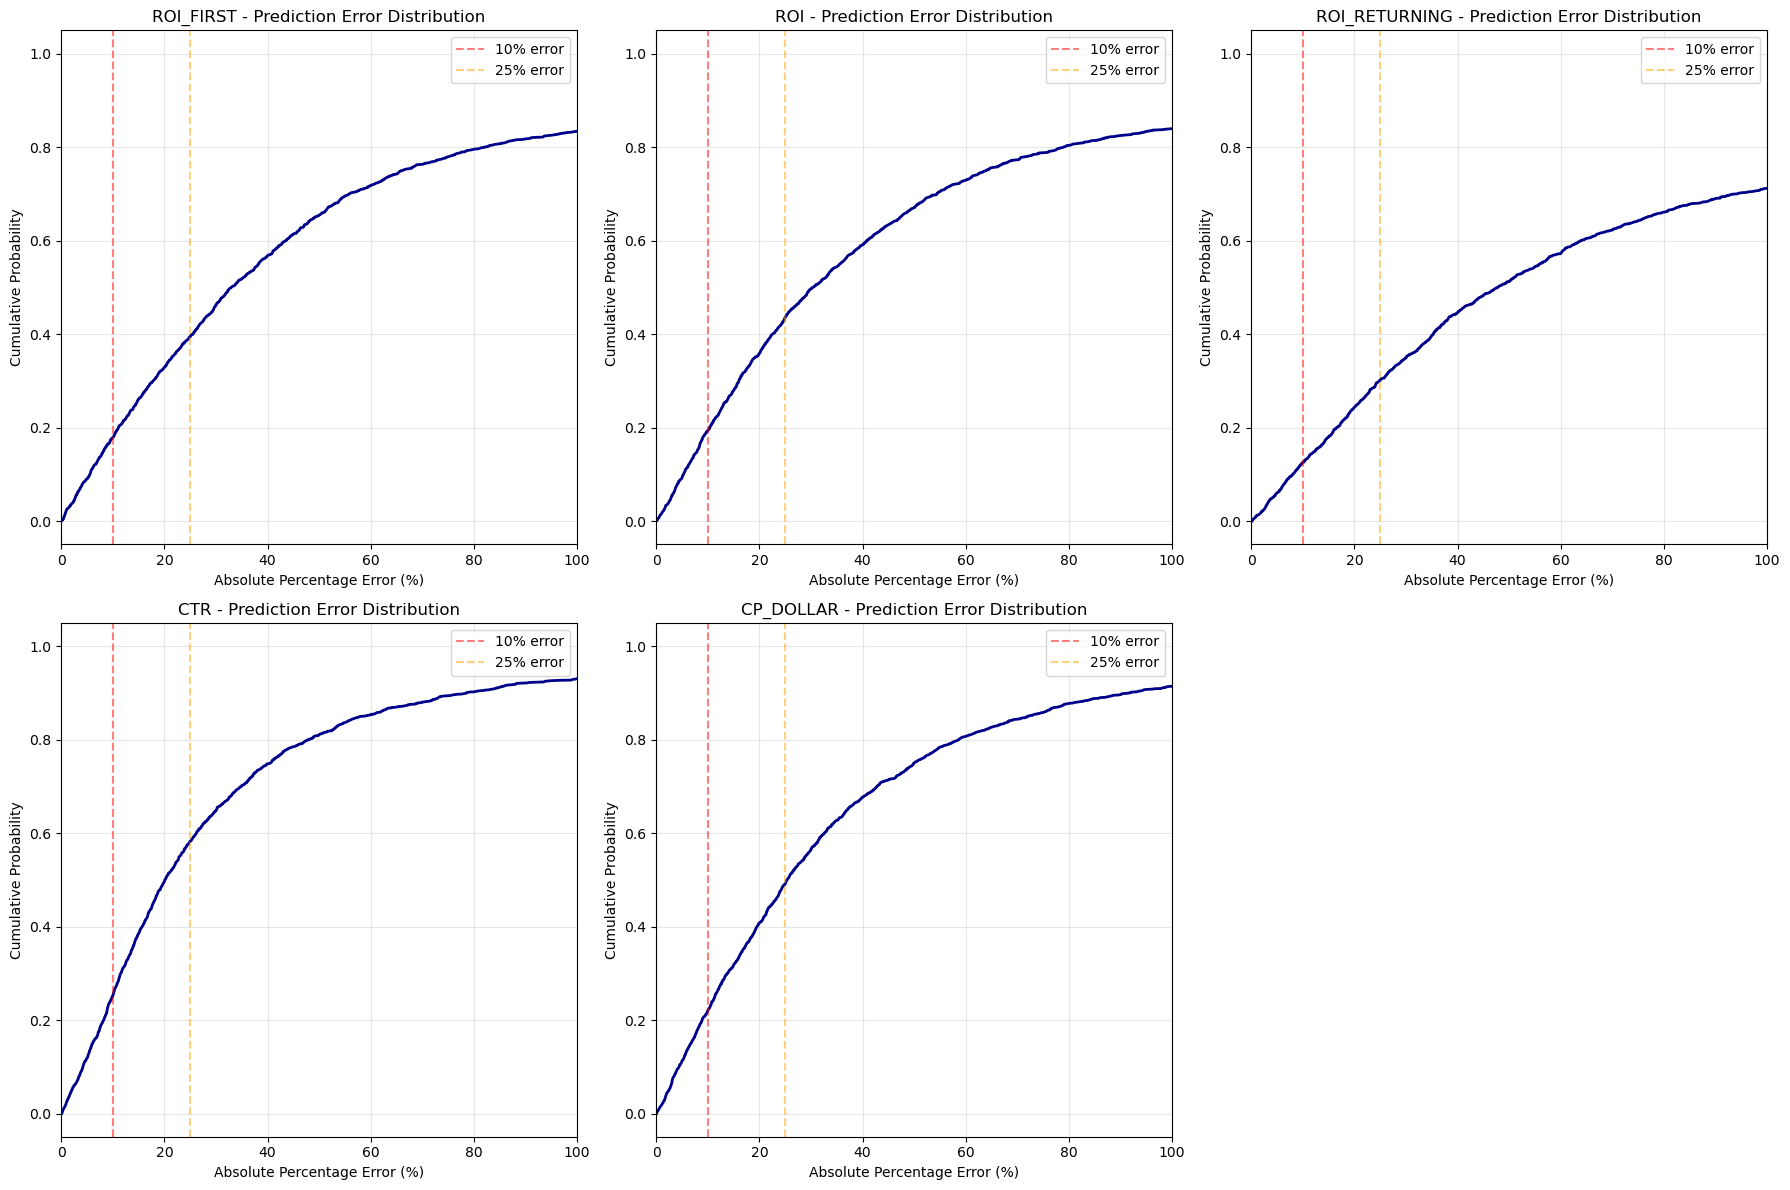

In [20]:
# Plot 6: Prediction Error Distribution (similar to AUC concept for regression)
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, target in enumerate(target_variables):
    y_true = results[target]['y_true']
    y_pred = results[target]['y_pred']
    
    # Calculate percentage errors
    # Avoid division by zero
    mask = y_true != 0
    percentage_errors = np.abs((y_true[mask] - y_pred[mask]) / y_true[mask]) * 100
    
    # Plot cumulative distribution
    sorted_errors = np.sort(percentage_errors)
    cumulative = np.arange(1, len(sorted_errors) + 1) / len(sorted_errors)
    
    axes[idx].plot(sorted_errors, cumulative, linewidth=2, color='darkblue')
    axes[idx].axvline(x=10, color='red', linestyle='--', alpha=0.5, label='10% error')
    axes[idx].axvline(x=25, color='orange', linestyle='--', alpha=0.5, label='25% error')
    axes[idx].set_xlabel('Absolute Percentage Error (%)')
    axes[idx].set_ylabel('Cumulative Probability')
    axes[idx].set_title(f'{target} - Prediction Error Distribution')
    axes[idx].legend()
    axes[idx].grid(alpha=0.3)
    axes[idx].set_xlim(0, min(100, np.percentile(sorted_errors, 95)))

# Hide the extra subplot
axes[5].axis('off')

plt.tight_layout()
plt.show()


In [21]:
# Create a comprehensive feature importance comparison
importance_df = pd.DataFrame()

for target in target_variables:
    model = models[target]
    importance_df[target] = model.feature_importances_

importance_df.index = X_train.columns

for target in target_variables:
    print(f"\n{target}:")
    top_features = importance_df[target].sort_values(ascending=False).head(5)
    for feature, importance in top_features.items():
        print(f"  {feature}: {importance:.4f}")



ROI_FIRST:
  TOTAL_SPEND: 0.3127
  TOTAL_IMPRESSIONS: 0.0785
  META_FACEBOOK_SPEND: 0.0780
  META_FACEBOOK_IMPRESSIONS: 0.0583
  GOOGLE_SHOPPING_SPEND: 0.0535

ROI:
  TOTAL_SPEND: 0.2873
  META_FACEBOOK_IMPRESSIONS: 0.0630
  GOOGLE_VIDEO_IMPRESSIONS: 0.0592
  GOOGLE_PMAX_IMPRESSIONS: 0.0534
  META_FACEBOOK_SPEND: 0.0525

ROI_RETURNING:
  TOTAL_SPEND: 0.1973
  META_INSTAGRAM_IMPRESSIONS: 0.0764
  TOTAL_IMPRESSIONS: 0.0726
  GOOGLE_PAID_SEARCH_IMPRESSIONS: 0.0659
  META_FACEBOOK_IMPRESSIONS: 0.0618

CTR:
  TOTAL_IMPRESSIONS: 0.2664
  TOTAL_SPEND: 0.0759
  GOOGLE_SHOPPING_SPEND: 0.0670
  GOOGLE_PMAX_IMPRESSIONS: 0.0587
  GOOGLE_PAID_SEARCH_SPEND: 0.0529

CP_DOLLAR:
  TOTAL_IMPRESSIONS: 0.1563
  TOTAL_SPEND: 0.1498
  META_FACEBOOK_IMPRESSIONS: 0.0936
  META_FACEBOOK_SPEND: 0.0825
  GOOGLE_SHOPPING_SPEND: 0.0819


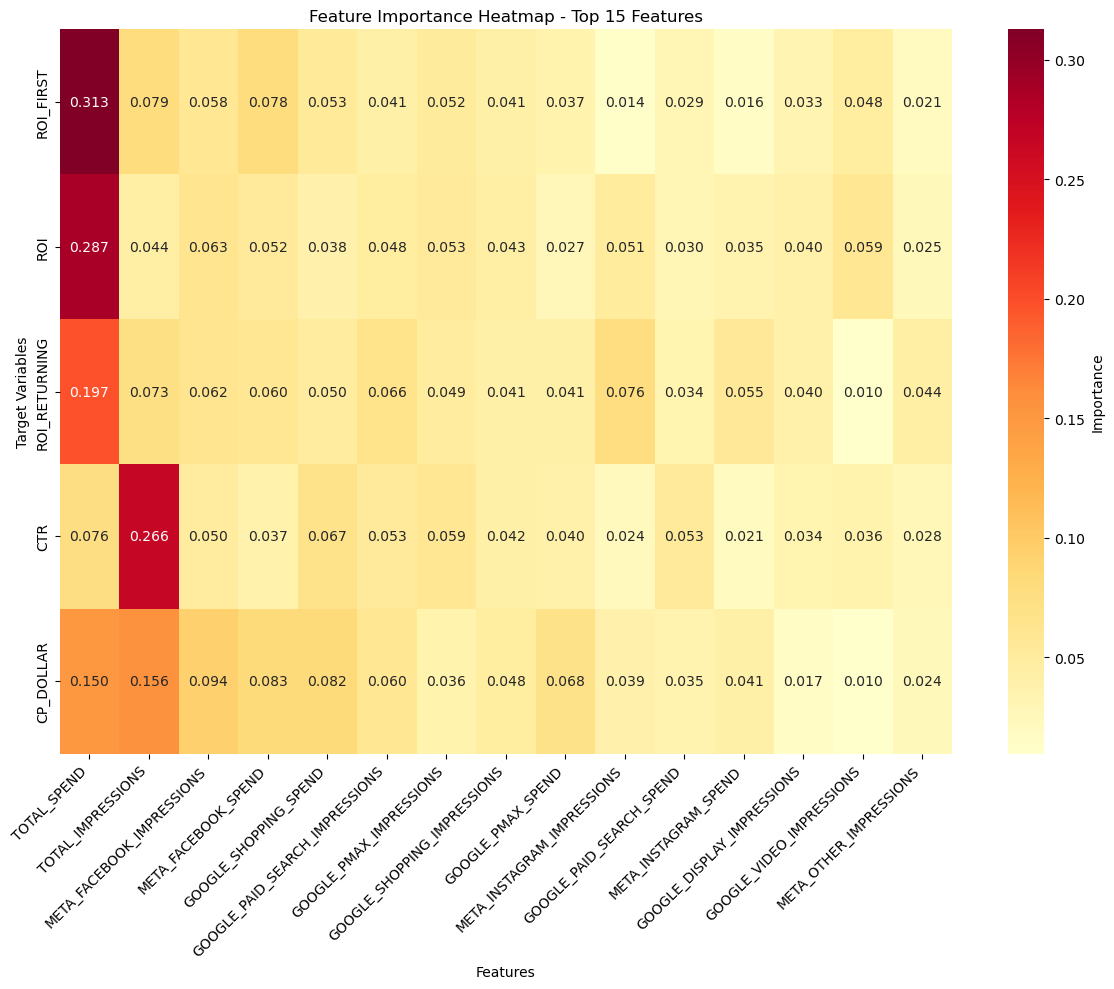

In [22]:
# Heatmap of feature importance across all models
plt.figure(figsize=(12, 10))

# Get top 15 most important features across all models
avg_importance = importance_df.mean(axis=1).sort_values(ascending=False)
top_features = avg_importance.head(15).index

# Create heatmap
sns.heatmap(importance_df.loc[top_features].T, annot=True, fmt='.3f', cmap='YlOrRd', cbar_kws={'label': 'Importance'})
plt.title('Feature Importance Heatmap - Top 15 Features')
plt.xlabel('Features')
plt.ylabel('Target Variables')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
